<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment01/PCD_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#
##Nama  : Sapto Nugroho
##NIU   : 565712

###git clone

In [1]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

sample_data
Cloning into 'PCD'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 107 (delta 32), reused 33 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 1.10 MiB | 7.95 MiB/s, done.
Resolving deltas: 100% (32/32), done.
PCD  sample_data


###Import

In [2]:
import cv2
import pandas as pd
import numpy as np
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import statistics as st

###Image Acquisition

In [52]:
def Acquire(src,size):
  #Image and Copy
  img = plt.imread(src)
  img_copy = img.copy()

  #Plot Image dan Copy
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img)
  axs[0].set_title(f"Before, shape, {img.shape}")
  axs[1].imshow(img_copy)
  axs[1].set_title(f"After, shape {img_copy.shape}")
  plt.tight_layout()
  plt.show()

  return img, img_copy


###Downsampling

In [ ]:
def DownSample(img_copy,order,size):
  div = 2**order

  #baris
  baris = img_copy.shape[0]//div
  print(f"baris = {baris}, sisa baris = {img_copy.shape[0]%div}")

  #kolom
  kolom = img_copy.shape[1]//div
  print(f"kolom = {kolom}, sisa kolom = {img_copy.shape[1]%div}")

  #Matriks Image DownSample (img_ds)
  img_ds = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
  print(img_copy.shape,"==>",img_ds.shape)
  #print(img_ds)

  #DownSampling
  for j in range(0,img_ds.shape[0]):
    # print("J= ",j,j*div)
    for i in range(0,img_ds.shape[1]):
      # print(i, i*div)
      img_ds[j][i] = img_copy[j*div][i*div]

  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_ds)
  axs[1].set_title(f"After, shape {img_ds.shape}")
  plt.tight_layout()
  plt.show()

  return img_ds

img_ds = DownSample(img_copy,1,8)
# print(img_ds)


###Decimation

In [93]:
def Decimate(img_copy,order,mode,size):
  div = 2**order

  #baris
  baris = img_copy.shape[0]//div
  print(f"baris = {baris}, sisa baris = {img_copy.shape[0]%div}")

  #kolom
  kolom = img_copy.shape[1]//div
  print(f"kolom = {kolom}, sisa kolom = {img_copy.shape[1]%div}")

  #Matriks Image Decimation (img_dc)
  # img_dc = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
  img_dc = np.zeros(shape=(baris,kolom,3),dtype=int)
  print(img_copy.shape,"==>",img_dc.shape)
  # print(img_copy)
  # print(img_dc)

  #Decimation
  match mode:

    case 0:#Max
      mode = "Max"
      for h in range(0,img_dc.shape[0]):
        for i in range(0,img_dc.shape[1]):
          for j in range(h*div,(h+1)*div):
            for k in range(i*div,(i+1)*div):
              img_dc[h][i][0] = max(img_dc[h][i][0],img_copy[j][k][0])
              img_dc[h][i][1] = max(img_dc[h][i][1],img_copy[j][k][1])
              img_dc[h][i][2] = max(img_dc[h][i][2],img_copy[j][k][2])

    case 1:#Median
      mode = "Median"
      temp = [[],[],[]]
      img_copy = img_copy.astype(int)
      for h in range(0,img_dc.shape[0]):
        for i in range(0,img_dc.shape[1]):
          for j in range(h*div,(h+1)*div):
            for k in range(i*div,(i+1)*div):
              temp[0].append(img_copy[j][k][0])
              temp[1].append(img_copy[j][k][1])
              temp[2].append(img_copy[j][k][2])
          img_dc[h][i][0] = st.median(temp[0])
          img_dc[h][i][1] = st.median(temp[1])
          img_dc[h][i][2] = st.median(temp[2])
          temp = [[],[],[]]
      img_dc = img_dc.astype(np.uint8)

    case 2:#Mean
      mode = "Mean"
      for h in range(0,img_dc.shape[0]):
        for i in range(0,img_dc.shape[1]):
          for j in range(h*div,(h+1)*div):
            for k in range(i*div,(i+1)*div):
              img_dc[h][i] += img_copy[j][k]
              # print(f"B[{h}][{i}]<==A[{j}][{k}]")
              # print("A:",img_copy[j][k])
              # print("B:\n",img_dc)
          img_dc[h][i] = np.round(img_dc[h][i]/(div*div))
      # print(img_dc)
      img_dc = img_dc.astype(np.uint8)



  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_dc)
  axs[1].set_title(f"After, shape {img_dc.shape}")

  fig.suptitle(f"Decimation({mode})", fontsize=18)
  plt.tight_layout()
  plt.subplots_adjust(top=1.35)
  plt.show()

  return img_dc


###Testing

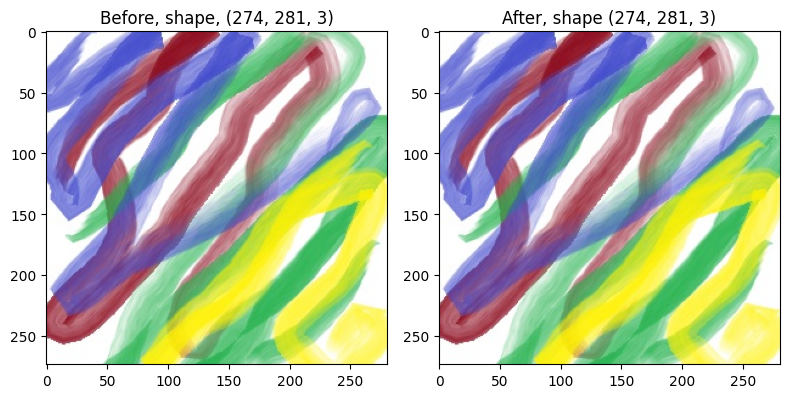

In [48]:
# img_path = '/content/PCD/PCD_Assignment01/grid.jpg'
# img_path = '/content/PCD/PCD_Assignment01/4x4.jpg'
# img_path = '/content/PCD/PCD_Assignment01/8x8.jpg'
# img_path = '/content/PCD/PCD_Assignment01/16x16.jpg'
# img_path = '/content/PCD/PCD_Assignment01/64x64.jpg'
# img_path = '/content/PCD/PCD_Assignment01/128x128.jpg'
# img_path = '/content/PCD/PCD_Assignment01/color01.jpg'
img_path = '/content/PCD/PCD_Assignment01/color02.jpg'
# img_path = '/content/PCD/PCD_Assignment01/clouds.jpg'

img,img_copy = Acquire(img_path)
# print(img[0][0],img_copy[-1][-1])

baris = 68, sisa baris = 2
kolom = 70, sisa kolom = 1
(274, 281, 3) ==> (68, 70, 3)


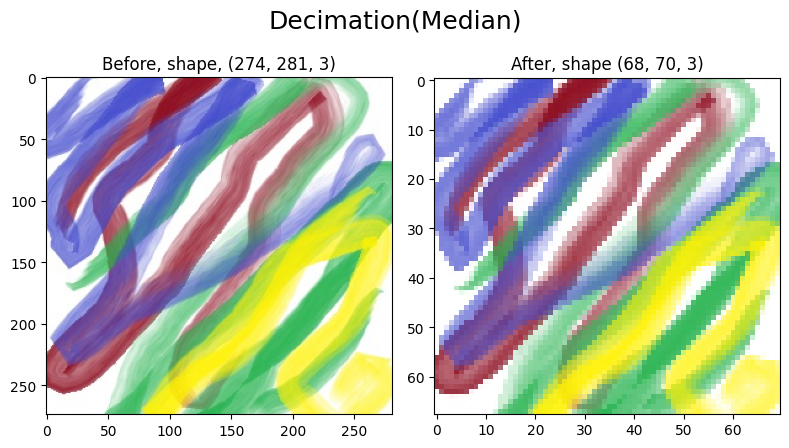

In [95]:
# Decimate(img_copy,order,mode,size)
img_dc = Decimate(img_copy,2,1,8)

##junk

In [ ]:
# img2 = mpimg.imread(img02_path)
# plt.imshow(img2)
# plt.axis('off')
# plt.show()

In [ ]:
A = np.random.randint(0, 10, size=(8, 8))
print(A)

B = np.zeros(shape=(2,2))
print(B)

div = 2**2

for h in range(0,B.shape[0]):
  for i in range(0,B.shape[1]):
    for j in range(h*div,(h+1)*div):
      for k in range(i*div,(i+1)*div):
        print(f"B[{h}][{i}]<==A[{j}][{k}]")
        print("A:",A[j][k])
        B[h][i] += A[j][k]
        print("B:\n",B)
    B[h][i] = round((B[h][i])/div)

print(type(B[0][0]))


In [ ]:
# print(img02_copy[-1][-1])
print(MDS)
print("===============================")
M = np.array([1,2,3])
print(M.shape)
print(M)
M = M.reshape(1,3)
print(M.shape)
print(M)
print("===============================")
print(MDS[0].shape)
# MDS = np.append(M_DS,M)
MDS[0] = np.concatenate((MDS[0],M),axis=1)
# C = np.concatenate((M,MDS[0][0]),axis=0)
print(MDS[0][0].shape)
print(MDS)


In [ ]:
# pd.Series(img01.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

flat = img02.flatten()
# print(flat.shape)
# print(flat)

A = []

for i in range(len(flat)):
  if i%3==0:
    A.append(int(flat[i]))

A = np.array(A)
print(A[0].dtype)

# pd.Series(img02.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

int64


In [ ]:
A = np.zeros( (2, 3, 5) )
print("A = {}\n".format(A))
## 1rst term => depth
## 2 other terms => (i,j)

## basic 2D array
B = np.ones( (1,3, 5) )
print("B = {}\n".format(B))

## 2D array reshaped into 3D one prior to be concatenated
# Bprime = B.reshape(1,3,5)
# print("Bprime = {}\n".format(Bprime))

## C is created and suppoed to be A expanded by B
# C = np.concatenate( (A, Bprime) )
C = np.concatenate( (A, B), axis = 0)
print("C = {}\n".format(C))

In [ ]:
# length = len(flat)/3
# length = int(length)

# empty02 = np.zeros(shape=(length),dtype=np.uint8)
# print(empty02)